In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from scipy.signal import correlate, find_peaks
import sounddevice as sd
import wave
# matplotlib qt

# Microphone Parameters
1. Mic Gain: 80
2. Recording Mode: Ambisonics FuMa
3. Recording Format (Sampling Rate): 48kHz
4. Recording Format (Bit depth): 24-bit

In [2]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 4

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in meters)
triangle_side = 1.28
triangle_height = triangle_side * np.sqrt(3) / 2

# Constants for the attenuation function
frequency_dist_threshold = 0.9
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3
cutoff_freq = 5000 
indicator_threshold = 1.0 * (10 ** 8) # Volume threshold for cropping microphone signals

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 2))

mic_positions[0, :] = [0, 0]
mic_positions[1, :] = [triangle_side, 0]
mic_positions[2, :] = [triangle_side / 2, (triangle_side * np.sqrt(3)) / 2]

# Functions to calculate the attenuation of different microphones

In [3]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    # Equation (3)
    def l(d_m):
        # Piecewise function where:
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    # Equation (4)
    def k_p(d_m):
        # Piecewise function where:
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    # Component in equation (3)
    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    # Component in equation (4)
    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    # Equation (2)
    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

def distance_dependent_filtering(d_m, t_f=frequency_dist_threshold, s_f_neg=1.0):
    """
    Distance dependent h(d_m) first-order low-pass infinite impulse response
    filter whose cut-off frequency f_c is equal to 20kHz when d_m is below a 
    threshold value t_f, and falls linearly with a slope s_f < 0 when d_m is 
    above t_f.

    This simulates natural attenuation of high-frequency sounds that would occur
    over long distance. 

    d_m: Distance of microphone m to interpolated point
    t_f: Threshold value t_f
    """

    # Component in equation (7)
    def s_f(delta_d):
        # Adjust this function based on the specific behavior of s_f
        # For example, you can use a linear function: return s_f_neg * delta_d
        return s_f_neg * delta_d

    # Equation (7)
    def f_c(d_m, cutoff_freq):
        # Piecewise function where:
        # f_c(d_m) = 20000 if d_m <= t_f
        # f_c(d_m) = 20000 + s_f
        return np.where(d_m <= t_f, cutoff_freq, cutoff_freq + s_f(d_m - t_f))

    return f_c(d_m, cutoff_freq)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel]
    # X Channel
    x_signal = mic_signal[:, x_channel]
    # Y Channel
    y_signal = mic_signal[:, w_channel]
    # Z Channel
    z_signal = mic_signal[:, w_channel]

    return w_signal, x_signal, y_signal, z_signal


In [4]:
from pydub import AudioSegment

def get_num_channels(wav_file_path):
    audio = AudioSegment.from_file(file=wav_file_path, format="wav")  
    num_channels = audio.channels
    return num_channels

# Function to plot four different waves
def plot_waves(time_axis, signal, title, xlabel='Time', ylabel='Amplitude'):
    # Extracting the channels
    w, x, y, z = extract_channels(signal)
    # Plotting the W componment
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, w, color='blue')
    plt.title(f'{title} W component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Plotting the X component
    plt.subplot(2, 2, 2)
    plt.plot(time_axis, x, color='green')
    plt.title(f'{title} X component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Y component
    plt.subplot(2, 2, 3)
    plt.plot(time_axis, y, color='red')
    plt.title(f'{title} Y component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Z component
    plt.subplot(2, 2, 4)
    plt.plot(time_axis, z, color='orange')
    plt.title(f'{title} Z component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()

# Function to plot a particular signal
def plot_signal(time, signal, title, color='blue'):
    plt.plot(time, signal, color)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# Plotting the fourier transform of a signal
def plot_fourier_transform(signal, fs, title):
    """
    Plots the Fourier Transform of a given signal.

    Args:
        signal: The input signal (time-domain).
        fs: The sampling rate (in Hz).
    """
    # Compute the Fourier Transform
    N = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1/fs)

    # Only plot the positive frequencies
    mask = xf > 0

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(xf[mask], 2.0/N * np.abs(yf[mask]))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

# Cropping in audacity
This step is not present in the code, but it is a step that should be done using
audacity. Just crop the front and ends of the audio, but leave the indicator A notes.

In [5]:
'''
No code here, refer to markdown description
'''

'\nNo code here, refer to markdown description\n'

In [6]:
fs, test_signal = wavfile.read('../data/06_04_expts/mic1_6apr/mic1_007.WAV')
print(test_signal.dtype)

int32


/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_36590/3638605686.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, test_signal = wavfile.read('../data/06_04_expts/mic1_6apr/mic1_007.WAV')


# Loading the audio
We will plot the signals in its four channels (w, x, y, z) to analyze the data.

(1285793, 4)
(1239674, 4)
(1261282, 4)
(1260879, 4)


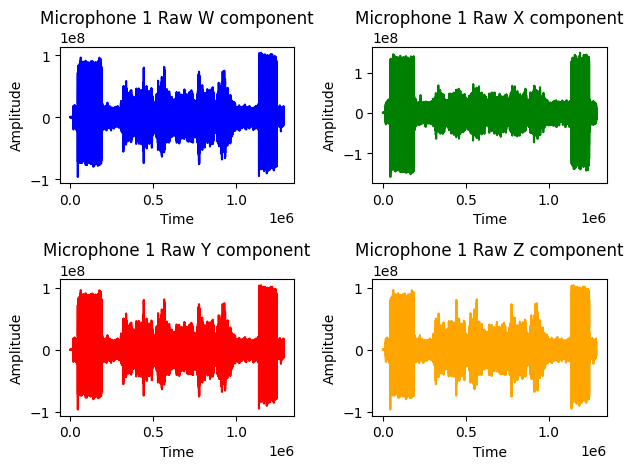

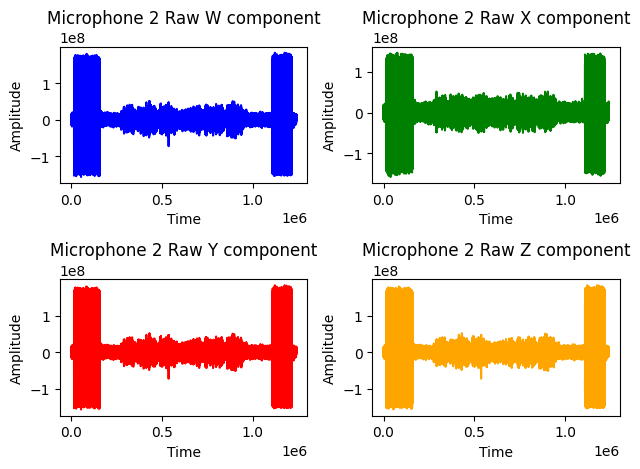

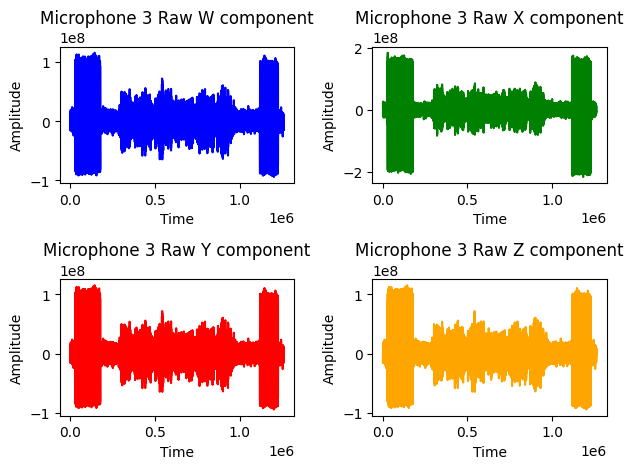

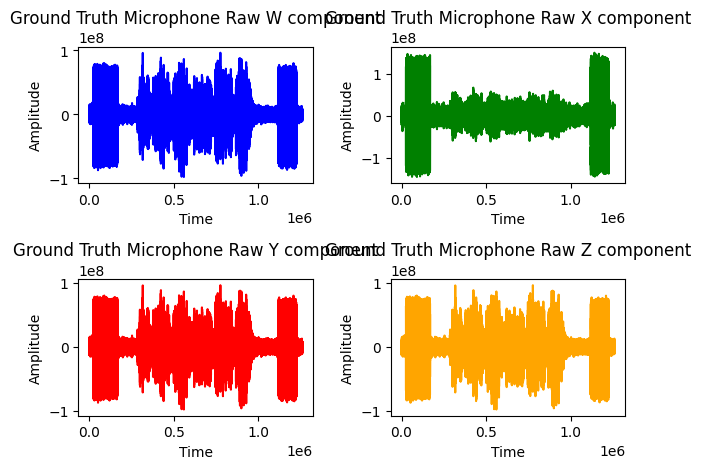

In [7]:
# Reading from the files
fs, mic1_signal = wavfile.read('../data/06_04_expts/mic1_6apr/mic1_007_cropped.WAV')
_, mic2_signal = wavfile.read('../data/06_04_expts/mic2_6apr/mic2_007_cropped.WAV')
_, mic3_signal = wavfile.read('../data/06_04_expts/mic3_6apr/mic3_007_cropped.WAV')
_, gt_signal = wavfile.read('../data/06_04_expts/gt_6apr/gt_007_cropped.WAV')

# Original time_axes
time_1 = np.arange(1, mic1_signal.shape[0] + 1)
time_2 = np.arange(1, mic2_signal.shape[0] + 1)
time_3 = np.arange(1, mic3_signal.shape[0] + 1)
time_gt = np.arange(1, gt_signal.shape[0] + 1)

print(mic1_signal.shape)
print(mic2_signal.shape)
print(mic3_signal.shape)
print(gt_signal.shape)

# Plotting the signals to check it out
plot_waves(time_1, mic1_signal, "Microphone 1 Raw")
plot_waves(time_2, mic2_signal, "Microphone 2 Raw")
plot_waves(time_3, mic3_signal, "Microphone 3 Raw")
plot_waves(time_gt, gt_signal, "Ground Truth Microphone Raw")


# Extracting the channels of the ambisonic microphone signals


In [8]:
# Extracting the data from each channel
mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal = extract_channels(mic1_signal)
mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal = extract_channels(mic2_signal)
mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal = extract_channels(mic3_signal)
gt_w_signal, gt_x_signal, gt_y_signal, gt_z_signal = extract_channels(gt_signal)

# Cropping the signal based on the indicator tones
In order for us to know which section of audio we're trying to analyze, we played an A-note before and after the recording. In this section, we will programatically filter the section of data we're using based on the A-note. 

Important note: We will crop based on the x-component

The cropping algorithm is as follows
1. Break the w_signal into w_signal_left and w_signal_right
2. Find the indices where it crosses the threshold
3. Take the last index of w_signal_left and first index of w_signal_right
4. Move back to original frame 
----> left_index = w_signal_left
----> right_index = w_signal_right + len(signal)/2
5. Crop the signals to be signal[left_index: right_index+1]

In [9]:
# Function to return the indices of values higher than indicator_threshold
def filter_signal_indices(mic, indicator_threshold):
    indices = []
    for i, value in enumerate(mic):
        value = abs(value)
        if value >= indicator_threshold:
            indices.append(i)
    return indices

# Creating an array of the microphones
mic_x_arr = [mic1_x_signal, mic2_x_signal, mic3_x_signal, gt_x_signal]

# Adding offset for number of indices
offset = 30

# Looping through every signal and starting the cropping
for i in range(len(mic_x_arr)):
    # Getting the microphone
    # Getting the x component of the microphone
    mic_x = mic_x_arr[i]

    # Getting the values for number of samples
    num_samples = len(mic_x)
    print(num_samples)
    mid = num_samples // 2
    
    # 1. Splitting the signals
    w_left = mic_x[:mid]
    w_right = mic_x[mid:]

    # Filtering based on amplitude
    # 2. Return the indices of samples where the values > indicator_threshold
    left_indices = filter_signal_indices(w_left, indicator_threshold)
    right_indices = filter_signal_indices(w_right, indicator_threshold)
    # 3. Returning the correct index
    cropped_start = left_indices[-1] + offset
    cropped_end = right_indices[0] + mid - offset # Must add mid to account for correct index

    # 4. Move back to original frame
    if (i == 0):
        mic1_signal = mic1_signal[cropped_start: cropped_end]
    elif (i == 1):
        mic2_signal = mic2_signal[cropped_start: cropped_end]
    elif (i == 2):
        mic3_signal = mic3_signal[cropped_start: cropped_end]
    elif (i == 3):
        gt_signal = gt_signal[cropped_start: cropped_end]



1285793
1239674
1261282
1260879


# Verification

Once we have programatically cropped the signals, this is to check that the data has the same number of samples. 

We also want to plot the new signals to make sure we're getting the right thing. 

In [10]:
# Getting the number of samples
mic1_samples = mic1_signal.shape[0]
mic2_samples = mic2_signal.shape[0]
mic3_samples = mic3_signal.shape[0]
gt_samples = gt_signal.shape[0]

print(mic1_samples, mic2_samples, mic3_samples, gt_samples)

min_length = min([mic1_samples, mic2_samples, mic3_samples, gt_samples])

# Cropping all of them to min_length
mic1_signal = mic1_signal[:min_length]
mic2_signal = mic2_signal[:min_length]
mic3_signal = mic3_signal[:min_length]
gt_signal = gt_signal[:min_length]

# Verifying that they are all min_length
assert(mic1_signal.shape[0] == mic2_signal.shape[0] == mic3_signal.shape[0] == gt_signal.shape[0])


949526 950080 945271 950179


(945271, 4)
(945271, 4)
(945271, 4)
(945271, 4)


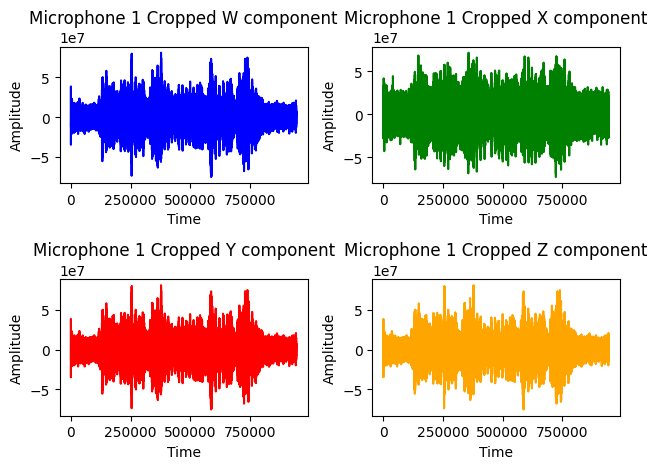

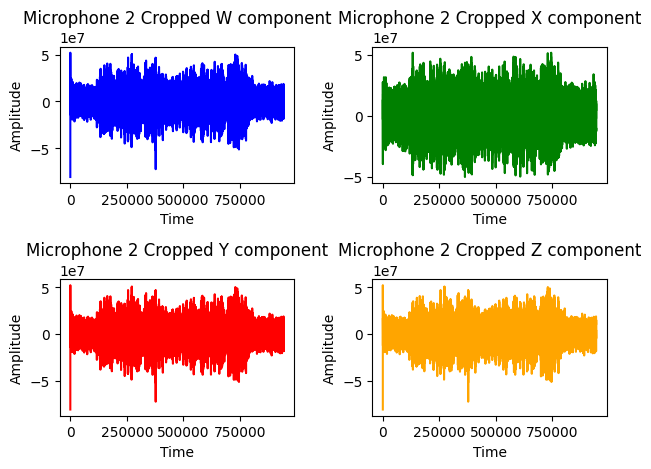

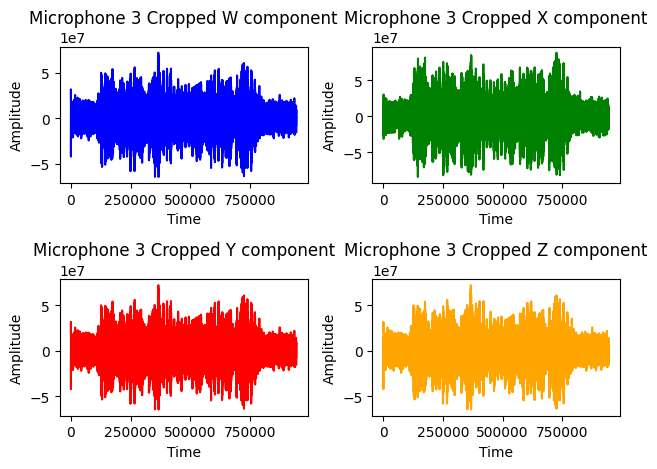

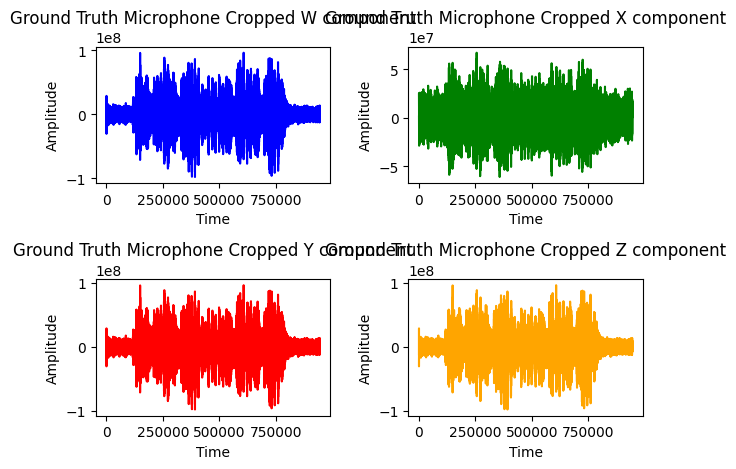

In [11]:
# Original time_axes
time_1 = np.arange(1, mic1_signal.shape[0] + 1)
time_2 = np.arange(1, mic2_signal.shape[0] + 1)
time_3 = np.arange(1, mic3_signal.shape[0] + 1)
time_gt = np.arange(1, gt_signal.shape[0] + 1)

print(mic1_signal.shape)
print(mic2_signal.shape)
print(mic3_signal.shape)
print(gt_signal.shape)

# Plotting the signals to check it out
plot_waves(time_1, mic1_signal, "Microphone 1 Cropped")
plot_waves(time_2, mic2_signal, "Microphone 2 Cropped")
plot_waves(time_3, mic3_signal, "Microphone 3 Cropped")
plot_waves(time_gt, gt_signal, "Ground Truth Microphone Cropped")

In [12]:
# Re-extracting the channels and update
mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal = extract_channels(mic1_signal)
mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal = extract_channels(mic2_signal)
mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal = extract_channels(mic3_signal)
gt_w_signal, gt_x_signal, gt_y_signal, gt_z_signal = extract_channels(gt_signal)

# Synchonizing the data

We will use the following procedure to synchronize the recordings on the three microphones

1. Apply a Fourier Transform on the omni-directional signals of the data
2. Find the time at which the start and end A notes of the fourier transform are
3. Do a sanity check to make sure the length of time for all four of them are the same or around the same
4. If it's the same, make sure they're the same data. (Do some sort of correlation maybe? )

# Interpolation
Here, we will start interpolating the microphone signals that we have

In [13]:
import scipy

# Forming the y_m_p array according to the paper
y_m_p = np.array([
    [mic1_w_signal, mic2_w_signal, mic3_w_signal],
    [mic1_x_signal, mic2_x_signal, mic3_x_signal],
    [mic1_y_signal, mic2_y_signal, mic3_y_signal],
    [mic1_z_signal, mic2_z_signal, mic3_z_signal]
])

# Interpolation point coordinates
# interp_point = np.array([triangle_side / 2, (triangle_side * np.sqrt(3)) / 4])  # Ground truth point

# Experiment 2
interp_point = np.array([triangle_side / 4, triangle_height / 4])
# interp_point = np.array([triangle_side / 2, 0.15])
print(f"Interpolated Point: {interp_point}")

# Compute the distance for all samples at once (This is the d_m function)
distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])
print(f"Distances: {distances}")

# Compute the attenuation coefficients for each microphone using broadcasting (This calculates the a_p(d_m))
a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])
print(f"Attenuation values: {a_p_values}")

# Computing the filtered kernel
f_c = distance_dependent_filtering(distances[:, np.newaxis])
print(f"Cutoff frequencies: {f_c}")

# Creating the filters based on the cutoff frequencies
num_taps = 101  # Can be adjusted based on your requirements

# Initialize an empty array to hold the filtered signals
y_m_p_filtered = np.zeros_like(y_m_p)

# Convolving y_m_p with the low pass filter
for i in range(f_c.shape[0]):
    # Design a low-pass FIR filter for the current microphone
    h_filter = scipy.signal.firwin(num_taps, f_c[i, 0], fs=fs, pass_zero='lowpass')
    
    # Apply the filter to each signal for the current microphone
    for j in range(y_m_p.shape[0]):
        y_m_p_filtered[j, i] = scipy.signal.convolve(y_m_p[j, i], h_filter, mode='same')  # 'same' keeps the output length the same as the input

# Getting x_p 
print(a_p_values.shape)
print(y_m_p_filtered.shape)
x_p = np.sum(a_p_values * y_m_p_filtered, axis=1)
x_p = x_p.T


Interpolated Point: [0.32       0.27712813]
Distances: [0.42332021 0.99919968 0.8908423 ]
Attenuation values: [[1.        ]
 [0.98864418]
 [1.        ]]
Cutoff frequencies: [[5000.        ]
 [5000.09919968]
 [5000.        ]]
(3, 1)
(4, 3, 945271)


# Fourier Transforms
I realized that there was a lot of noise in the interpolated generation, probably from interpolating multiple microphones. Thus, we want to convert both the interpolated output (x_p) and the ground truth signal (gt_signal) and see what potentially could have led to the noise.

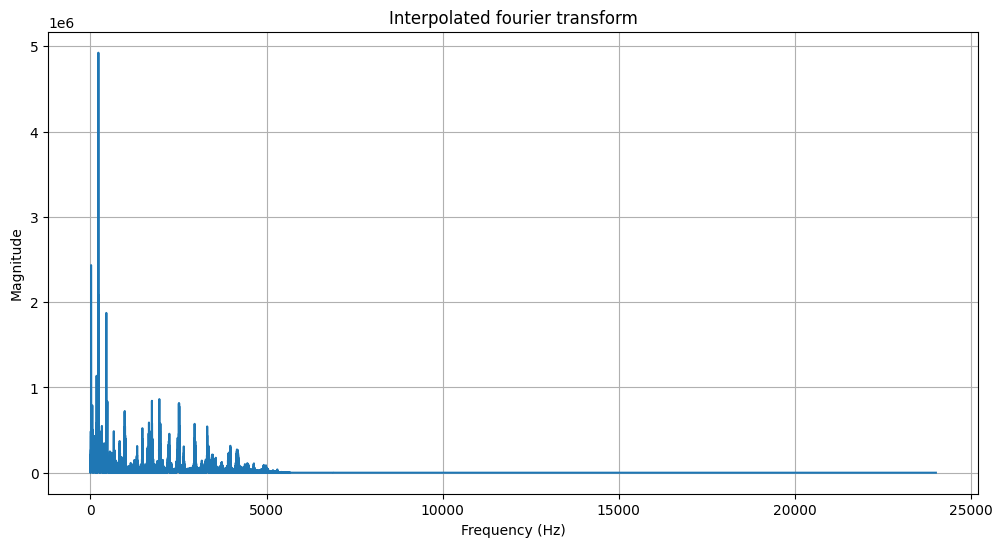

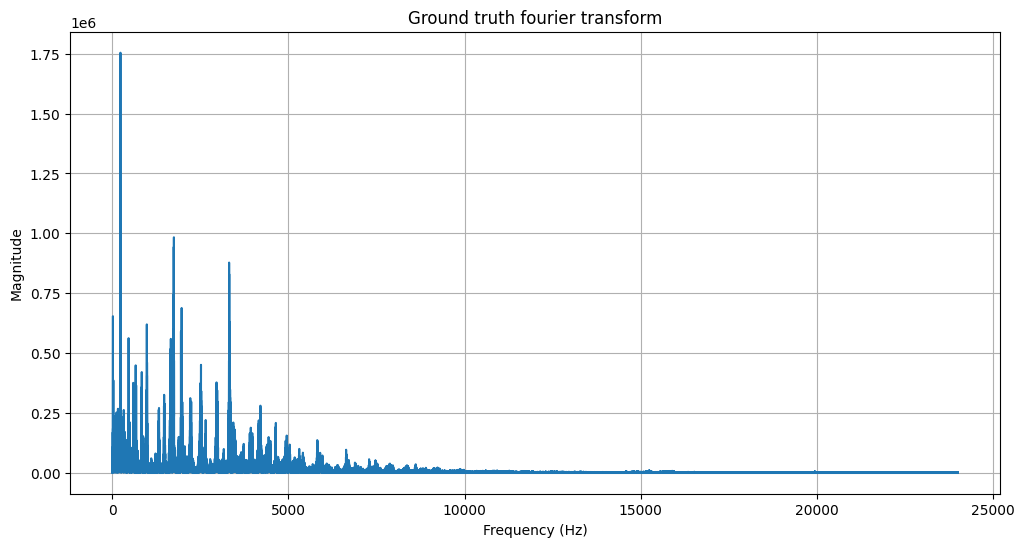

In [14]:
# Plotting the fourier transforms of x_p and g_t

x_p_w, x_p_x, x_p_y, x_p_z = extract_channels(x_p)
gt_w, gt_x, gt_y, gt_z = extract_channels(gt_signal)

plot_fourier_transform(x_p_w, fs, "Interpolated fourier transform")
plot_fourier_transform(gt_w, fs, "Ground truth fourier transform")

In [15]:
# Note: We must change the data type to fit original audio type
x_p_int = x_p.astype(np.int16)
# Saving the interpolated point as a wave file
wavfile.write('../output/output_centroid.wav', fs, x_p_int)


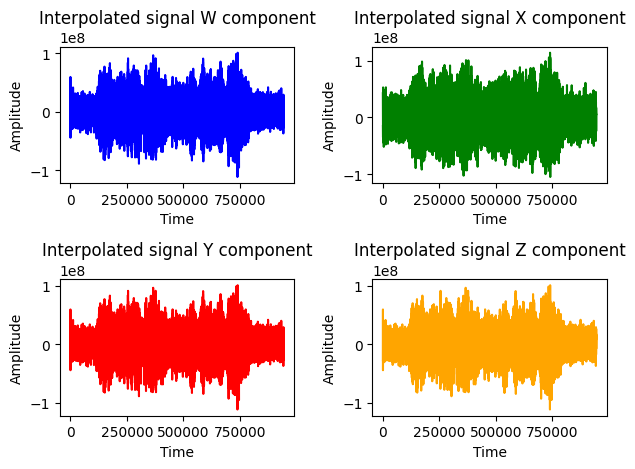

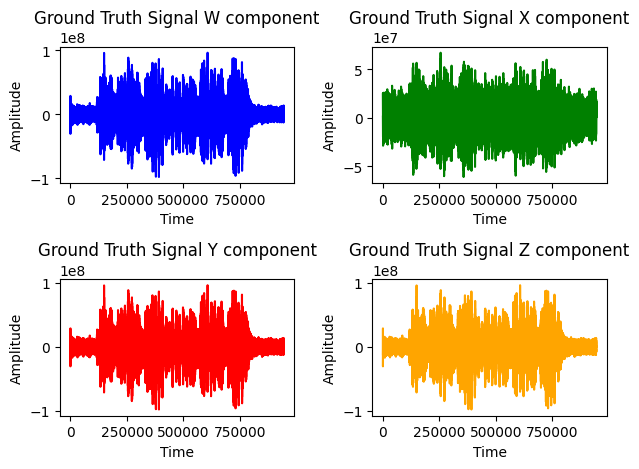

In [16]:
# Plotting the interpolated signal
time_axis = np.arange(1, x_p.shape[0] + 1)
assert(len(time_axis) == gt_signal.shape[0])
plot_waves(time_axis, x_p, 'Interpolated signal')

# Getting the ground truth signal
plot_waves(time_axis, gt_signal, 'Ground Truth Signal')

# Cross correlation
In this section, we will generate a bunch of points along the convex hull and perform interpolation on all those points. We will expect to see the best interpolation happening at the centroid

In [17]:
# Performing cross correlation
from scipy.signal import correlate

correlation_result = correlate(x_p, gt_signal, mode='full')

# Plot the similarity graph
plt.plot(correlation_result)
plt.title('Normalized Cross-correlation Coefficient')
plt.xlabel('Lag')
plt.ylabel('Similarity')
plt.show()

# Verification of maximum correlation

In [ ]:
# 1. Array of points of y-values
points = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
num_points = len(points)
signals = []

# Array of cross correlation values
cross_corr_values = []

# Getting the values of cross_correlations
for i in range(num_points):
    y_point = points[i]
    interp_point = np.array([triangle_side / 4, y_point])
    print(f"Interpolated point: {interp_point}")
    distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])
    print(f"Distances: {distances}")

    a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])
    print(f"Attenuation values: {a_p_values}")

    f_c = distance_dependent_filtering(distances[:, np.newaxis])
    print(f"Frequency filtering values: {f_c}")
    y_m_p_filtered = np.zeros_like(y_m_p)

    # Iterate over each microphone
    for i in range(f_c.shape[0]):
        # Design a low-pass FIR filter for the current microphone
        h_filter = scipy.signal.firwin(num_taps, f_c[i, 0], fs=fs, pass_zero='lowpass')
        
        # Apply the filter to each signal for the current microphone
        for j in range(y_m_p.shape[0]):
            y_m_p_filtered[j, i] = scipy.signal.convolve(y_m_p[j, i], h_filter, mode='same')  # 'same' keeps the output length the same as the input

    x_p = np.sum(a_p_values * y_m_p_filtered, axis=1)
    x_p = x_p.T
    signals.append(x_p)

Interpolated point: [0.32 0.05]
Distances: [0.32388269 0.9613012  1.10582492]
Attenuation values: [[1.        ]
 [0.99296728]
 [0.97658209]]
Frequency filtering values: [[5000.        ]
 [5000.0613012 ]
 [5000.20582492]]
Interpolated point: [0.32 0.15]
Distances: [0.35341194 0.97164808 1.01051781]
Attenuation values: [[1.        ]
 [0.99178514]
 [0.98735677]]
Frequency filtering values: [[5000.        ]
 [5000.07164808]
 [5000.11051781]]
Interpolated point: [0.32 0.25]
Distances: [0.40607881 0.99201814 0.91621162]
Attenuation values: [[1.        ]
 [0.98946194]
 [0.99813531]]
Frequency filtering values: [[5000.        ]
 [5000.09201814]
 [5000.01621162]]
Interpolated point: [0.32 0.35]
Distances: [0.47423623 1.02181212 0.82325041]
Attenuation values: [[1.        ]
 [0.98607374]
 [1.        ]]
Frequency filtering values: [[5000.        ]
 [5000.12181212]
 [5000.        ]]
Interpolated point: [0.32 0.45]
Distances: [0.55217751 1.06023582 0.73214666]
Attenuation values: [[1.        ]
 [0.

In [ ]:
# Cross correlating the signals
i = 0
for signal in signals:
    print(f"Correlating: {i}")
    print(f"Correlating current y-point: {points[i]}")
    cross_corr = correlate(gt_signal, signal, mode='full')
    print(f"Successfully correlated: {i}")
    cross_corr_values.append(cross_corr)
    i += 1
    
# Identifying time shifts
time_shifts = [np.argmax(cross_corr) - (len(gt_signal) - 1) for cross_corr in cross_corr_values]
print(f"Time difference between ground truth and gt_signal: {time_shifts}")

# Quantifying similarities
max_corr_values = [np.max(cross_corr) for cross_corr in cross_corr_values]
print(f"Max correlation values: {max_corr_values}")

most_similar_index = np.argmax(max_corr_values)
most_similar_signal = signals[most_similar_index]

# We expect it to say 55
print(f"The most signal is the one with y value: {points[most_similar_index]}")

Correlating: 0
Correlating current y-point: 0.05
Successfully correlated: 0
Correlating: 1
Correlating current y-point: 0.15
Successfully correlated: 1
Correlating: 2
Correlating current y-point: 0.25
Successfully correlated: 2
Correlating: 3
Correlating current y-point: 0.35
Successfully correlated: 3
Correlating: 4
Correlating current y-point: 0.45
Successfully correlated: 4
Correlating: 5
Correlating current y-point: 0.55
Successfully correlated: 5
Correlating: 6
Correlating current y-point: 0.65
Successfully correlated: 6
Correlating: 7
Correlating current y-point: 0.75
Successfully correlated: 7
Correlating: 8
Correlating current y-point: 0.85
Successfully correlated: 8
Correlating: 9
Correlating current y-point: 0.95
Successfully correlated: 9
Time difference between ground truth and gt_signal: [5675445, 5675445, 5675445, 5675445, 5675445, 5675445, 5675445, 5675445, 5675445, 5675445]
Max correlation values: [1.3538312011559485e+20, 1.3527639915214198e+20, 1.3516814711395136e+20, 

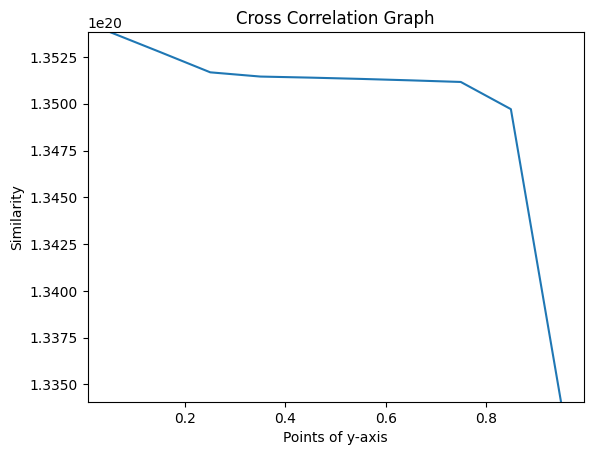

In [ ]:
# Normalize the max_corr_values:

# Plotting the graph
plt.plot(points, max_corr_values)
lower_bound = np.min(max_corr_values)
upper_bound = np.max(max_corr_values)
plt.ylim(lower_bound, upper_bound)
plt.title("Cross Correlation Graph")
plt.xlabel("Points of y-axis")
plt.ylabel("Similarity")
plt.show()
